In [ ]:

# learn the states of a double dot
import numpy as np
import tensorflow as tf
import glob
import os

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,100,100,1]),tf.float32)
    
    # Concolutional layer1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[10,10],
        padding="same",
        activation=tf.nn.relu)

    # Pooling layer1
    pool1 = tf.layers.max_pooling2d(inputs=conv1,pool_size=[5,5],strides=5)

    # Dense layer
    pool2_flat = tf.contrib.layers.flatten(pool1)
    dense0 = tf.layers.dense(inputs=pool2_flat,units=512,activation=tf.nn.relu)
    dropout0 = tf.layers.dropout(inputs=dense0,rate=0.5,training=mode == learn.ModeKeys.TRAIN)
    
    dense1 = tf.layers.dense(inputs=dropout0,units=256,activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1,rate=0.5,training=mode == learn.ModeKeys.TRAIN)
    
    dense2 = tf.layers.dense(inputs=dropout1,units=128,activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(inputs=dense2,rate=0.5,training=mode == learn.ModeKeys.TRAIN)

    # encode layer
    encode = tf.layers.dense(inputs=dropout2,units=8)
    
    # dense output layer
    out_layer = tf.layers.dense(inputs=encode,units=10000)

    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out_layer)

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=0.01,
            optimizer="Adam")

    # Generate predictions
    predictions= {
        "states" : tf.rint(out_layer),
    }

    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
    
def get_train_inputs():
    n_batch = 50
    index = np.random.choice(np.arange(train_data.shape[0]),n_batch,replace=False)
    x = tf.constant(train_data[index])
    y = tf.constant(train_labels[index])
    return x,y

def get_test_inputs():
    x = tf.constant(test_data)
    y = tf.constant(test_labels)
    return x,y

# get the data
data_files = glob.glob(os.path.expanduser('~/dataproc/*100*.npy'))
inp = []
oup = []
for file in data_files:
    data_dict = np.load(file).item()
    inp += [data_dict['current_map']]
    oup += [data_dict['state_map'].flatten()]

inp = np.array(inp)
oup = np.array(oup)
n_samples = inp.shape[0]
train_sample_ratio = 0.9
n_train = int(train_sample_ratio * n_samples)
print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)
train_data = inp[:n_train]
train_labels = oup[:n_train]

test_data = inp[n_train:]
test_labels = oup[n_train:]

# create the estimator
dd_classifier = learn.Estimator(model_fn=cnn_model_fn)

# set up logging for predictions
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states"),
}
for _ in range(1):
    dd_classifier.fit(
        input_fn=get_train_inputs,
        steps=1000,
        monitors=[logging_hook])
    
    eval_results=dd_classifier.evaluate(input_fn=get_train_inputs,metrics=metrics,steps=1)
    print("Train accuracy",eval_results)
    eval_results=dd_classifier.evaluate(input_fn=get_test_inputs,metrics=metrics,steps=1)
    print("Validation accuracy",eval_results)

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)
eval_results=dd_classifier.evaluate(input_fn=get_test_inputs,metrics=metrics,steps=1)
print("Test accuracy",eval_results)

Total number of samples : 1534
Training samples : 1380
Test samples : 154
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_task_type': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_model_dir': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11b4f43c8>, '_environment': 'local', '_evaluation_master': '', '_save_summary_steps': 100, '_num_worker_replicas': 0, '_task_id': 0, '_tf_random_seed': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpvqdnona0/model.ckpt.
INFO:tensorflow:loss = 1.74658, step = 1
INFO:tensorflow:
INFO:tensorflow:global_step/sec: 0.751799
INFO:tensorflow:loss = 0.171681, step = 101 (133.037 sec)


In [4]:
res_list = []
for i,p in enumerate(predictions):
    res_list += [p['states'].reshape((100,100))]

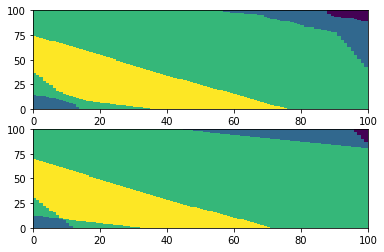

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(2,1,1)
plt.pcolor(res_list[0])
plt.subplot(2,1,2)
plt.pcolor(test_labels[0].reshape((100,100)))

In [94]:
res_list

[]

In [3]:
predictions = dd_classifier.predict(x=test_data)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmp85r_dchb/model.ckpt-1000


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt-2601


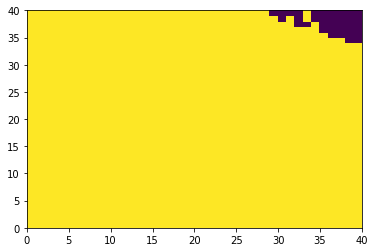

In [30]:
sub_image = np.zeros((100,100))
sub_image[50:90,50:90] = test_data[23][20:60,20:60]
sub_image_res = dd_classifier.predict(x=sub_image)
sub_res_list = []
for i,p in enumerate(sub_image_res):
    sub_res_list += [p['states'].reshape((100,100))]
plt.pcolor(sub_res_list[0][50:90,50:90])

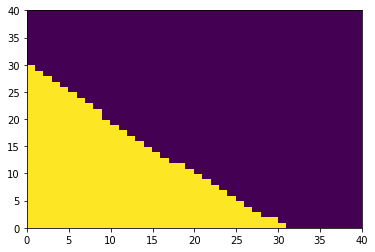

In [29]:
plt.pcolor(test_labels[23].reshape((100,100))[20:60,20:60])

In [27]:
diff = test_labels[23].reshape((100,100))[20:60,20:60] - sub_res_list[0][20:60,20:60]
np.sum(np.abs(diff))/1600

0.19062499999999999

In [142]:
# animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] ='/usr/local/bin/ffmpeg'
%matplotlib 

fig, ax = plt.subplots(1,2)
XX,YY = np.meshgrid(np.linspace(50e-3,500e-3,100),np.linspace(50e-3,500e-3,100))

def fixed_aspect_ratio(ax,ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = ax.axes.get_xlim(),ax.axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    ax.set_aspect(ratio*(xrange/yrange), adjustable='box')
    

def animate(i):
    my_cmap = mpl.colors.ListedColormap([[0., .4, 1.], [0., .8, 1.],
                                  [1., .8, 0.], [1., .4, 0.]])
    
    line = ax[0].pcolor(XX,YY,predictions_list[i][0],vmin=-1,vmax=2,cmap = my_cmap,alpha=0.9)
    fixed_aspect_ratio(ax[0],1.0)
    ax[0].set_title(r'Predicted $n_{iter} = $' + str(i*500))
    
    return line,


# Init only required for blitting to give a clean slate.
def init():
    
    my_cmap = mpl.colors.ListedColormap([[0., .4, 1.], [0., .8, 1.],
                                  [1., .8, 0.], [1., .4, 0.]])
    
    line = ax[0].pcolor(XX,YY,predictions_list[0][0],vmin=-1,vmax=2,cmap = my_cmap,alpha=0.9)
    fixed_aspect_ratio(ax[0],1.0)
    cbar_0 = plt.colorbar(line,ax=ax[0],cmap=my_cmap,ticks=[-1,0,1,2],fraction=0.046, pad=0.04)
    cbar_0.set_ticklabels(["SC","QPC","1Dot","2Dot"])
    cbar_0.set_ticks([-0.5,0.5,1.5,2.5])
    ax[0].set_xlabel(r'$V_{d1} (V)$',fontsize=12)
    ax[0].set_ylabel(r'$V_{d2} (V)$',fontsize=12)
    ax[0].set_title(r'Expected $n_{iter} = $' + str(0))
    ax[0].set_title('Predicted')
    
    
    line2 = ax[1].pcolor(XX,YY,test_labels[0].reshape((100,100)),vmin=-1,vmax=2,cmap = my_cmap,alpha=0.9)
    fixed_aspect_ratio(ax[1],1.0)
    cbar_1 = plt.colorbar(line2,ax=ax[1],cmap=my_cmap,ticks=[-1,0,1,2],fraction=0.046, pad=0.04)
    cbar_1.set_ticklabels(["SC","QPC","1Dot","2Dot"])
    cbar_1.set_ticks([-0.5,0.5,1.5,2.5])
    ax[1].set_xlabel(r'$V_{d1} (V)$',fontsize=12)
    ax[1].set_ylabel(r'$V_{d2} (V)$',fontsize=12)
    ax[1].set_title('Expected')
    plt.tight_layout()
    
    
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(100) , init_func=init,
                              interval=500, blit=True)

mywriter = animation.FFMpegWriter()
ani.save('dd_learning.mp4',writer=mywriter)

plt.show()

Using matplotlib backend: MacOSX


In [118]:
test_labels[0]

array([ 0,  0,  0, ..., -1, -1, -1])

In [125]:
predictions_list[0][18]

array([[ 0., -0., -0., ...,  0.,  0.,  0.],
       [-0.,  0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.]], dtype=float32)